# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
We have demonstrated the possible and colateral leakage of a trained model, but recall that we're most interested in Functional Encryption, and this means that all numbers sould actually be **integers** or at least **fixed precision** tensors. We'll leverage here the PySyft library which provides a way to directly use PyTorch in a fixed_precision scheme!

# 4 Quadratic model to fix precision


Let's define the precision fractional to be quite high, and we'll change it as we go.

In [17]:
PREC_FRAC = 5

Load torch packages

In [2]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
from learn import main, train, test, show_results, show_confusion_matrix

Let's load the quadratic model that we saved in Part 3! _Be sure that the path and file name match._

In [4]:
class QuadNet(nn.Module):
    def __init__(self, output_size):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, output_size)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

In [5]:
model = QuadNet(26)
path = '../data/models/quad_char.pt'
model.load_state_dict(torch.load(path))
model.eval()

QuadNet(
  (proj1): Linear(in_features=784, out_features=50, bias=True)
  (diag1): Linear(in_features=50, out_features=26, bias=True)
)

In [6]:
import syft as sy
hook = sy.TorchHook(torch)

We will now convert the model into fix precision, look how the `diag1.bias` changes for example!

In [7]:
model.diag1.bias

Parameter containing:
tensor([ 0.0023, -0.0051, -0.0100, -0.0098, -0.0150, -0.0051, -0.0088,  0.0042,
         0.0226,  0.0053,  0.0161,  0.0112, -0.0014, -0.0091, -0.0053,  0.0013,
         0.0153,  0.0002, -0.0161, -0.0422,  0.0151, -0.0122, -0.0231,  0.0025,
        -0.0005, -0.0092], requires_grad=True)

In [8]:
model.fix_precision(precision_fractional=PREC_FRAC)

QuadNet(
  (proj1): Linear(in_features=784, out_features=50, bias=True)
  (diag1): Linear(in_features=50, out_features=26, bias=True)
)

In [9]:
print(model.diag1.bias)

Parameter>FixedPrecisionTensor>tensor([  2310,  -5079,  -9969,  -9820, -15022,  -5135,  -8822,   4218,  22573,
          5288,  16118,  11198,  -1440,  -9074,  -5345,   1333,  15268,    247,
        -16146, -42179,  15099, -12185, -23097,   2475,   -496,  -9199])


We now define the elements necessary for performing an evaluation

In [10]:
import learn

In [11]:
class Parser:
    """Parameters for the testing"""
    def __init__(self):
        self.test_batch_size = 1000

And load the data!

In [12]:
torch.manual_seed(1)
args = Parser()

data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
test_target = test_target_char
test_dataset = learn.build_tensor_dataset(test_data, test_target)
test_loader = utils.DataLoader(
    test_dataset,
    batch_size=args.test_batch_size, shuffle=True
)

Training set 60000 items
Testing set  10000 items


Here comes th test phase, which in very close to `learn.test`. However, as you see we convert the data in fixed precision, and instead of a full forward pass, we omit the last log_softmax (by using `.transform`) as it should not be applied in the encryption part so not be applied on the integers. Hence, we apply it after the output is converted back to float.

In [13]:
def test(model, test_loader, prec_frac):
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data.fix_precision_(precision_fractional=prec_frac)
            output = model.transform(data)
            output = output.float_precision()
            output = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return acc

test(model, test_loader, PREC_FRAC)


/Users/ryffel/Documents/Code/PySyft/syft/frameworks/torch/tensors/interpreters/native.py:194: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = eval(cmd)(*args)



Test set: Average loss: 0.0002, Accuracy: 9503/10000 (95.03%)



95.03

Here are the resuls you obtain by changing the PREC_FRAC parameter:

In [14]:
prec_accuracy = {}
for prec_frac in range(1, 7):
    # THIS IS BECAUSE THE HOOK_ARGS MEMORIES THE FRAC PRECISION
    sy.frameworks.torch.hook_args.hook_method_response_functions = {}
    
    model = QuadNet(26)
    model.load_state_dict(torch.load(path))
    model.eval()
    model.fix_precision(precision_fractional=prec_frac)
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    acc = test(model, test_loader, prec_frac)
    print('prec', prec_frac, 'acc', acc)
    prec_accuracy[prec_frac] = acc

/Users/ryffel/Documents/Code/PySyft/syft/frameworks/torch/tensors/interpreters/native.py:194: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = eval(cmd)(*args)



Test set: Average loss: 0.0032, Accuracy: 546/10000 (5.46%)

prec 1 acc 5.46

Test set: Average loss: 0.0004, Accuracy: 8695/10000 (86.95%)

prec 2 acc 86.95

Test set: Average loss: 0.0002, Accuracy: 9493/10000 (94.93%)

prec 3 acc 94.93

Test set: Average loss: 0.0002, Accuracy: 9499/10000 (94.99%)

prec 4 acc 94.99

Test set: Average loss: 0.0002, Accuracy: 9503/10000 (95.03%)

prec 5 acc 95.03

Test set: Average loss: 0.0002, Accuracy: 9503/10000 (95.03%)

prec 6 acc 95.03


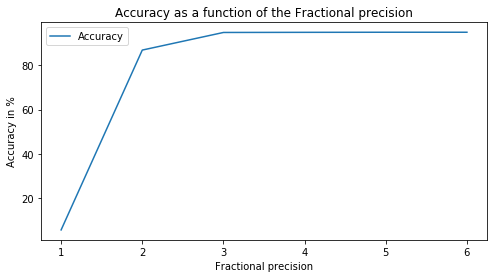

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(prec_accuracy.keys(), prec_accuracy.values(), label='Accuracy')
plt.ylabel('Accuracy in %')
plt.xlabel('Fractional precision')
plt.title('Accuracy as a function of the Fractional precision')
plt.legend()
plt.show()

As you observe, setting the fractional precision to 3 is far enough to have a very good accuracy compared to the best achievable.

Cool! Next question is: how does this impact the collateral learning? Response in Part 6!